In [42]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import random
import seaborn as sns
from wordfreq import word_frequency as wf

# File Initialization

In [2]:
Word_Bank_File_Name = 'words.csv'
Historical_File_Name = 'historical.txt'

In [18]:
#12000 word file stored as words_12k
words_12k=pd.read_csv('data/'+Word_Bank_File_Name)['words'].str.upper()



#Historical Words stored as words_historicals
historicals_txt=open('data/'+Historical_File_Name,'r').readlines()[0]
words_historicals=pd.DataFrame(historicals_txt.split(" "),columns=['words'])['words'].str.upper()


# Critical Definitions 

In [20]:
def unique(list1):
  
    
    unique_list = []
  
    
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
    

In [21]:
def getCharDistribution(word_list):
    Chars_List={}
    for word in words['words']:
        chars=unique([*word])
        for c in chars:
            if c not in Chars_List:
                Chars_List[c]=0
            Chars_List[c]+=1
    Sorted_Chars=dict(sorted(Chars_List.items(),key=lambda x:x[1],reverse=True))
    
    return Sorted_Chars
    



In [40]:
def getMaxFreq(word_corpus):
    
    Old=wf(word_corpus[0],'en')
    Word_Track=word_corpus[0]
    
    for word in word_corpus:
        New=max(wf(word,'en'),Old)
        if(New>Old):
            Word_Track=word
        
        Old=New
        
    return Word_Track

# Wordle Sim

In [22]:
class WordleSim:
    
    ##Initializes the state 2D array, with [guess letter, state]
    ## 0: Not in Word
    ## 1: Yellow
    ## 2: Green
    ## 
    
    def __init__(self,word):
        self.source_word=word
        self.num_tries=0
        self.Game_State=[[]]
        self.win=False
        
        for i in range(0,4):
            self.Game_State.append(["",-1])
        

    def __str__(self, word):
        self.source_word=word.upper()
        self.num_tries=0
        
    def play(self,guess):
        Char_List=[*guess.upper()]
        
        for i in range(0,len(Char_List)):
            state_var=0
            if Char_List[i]==[*self.source_word][i]:
                state_var=2
                
            elif Char_List[i] in [*self.source_word]:
                state_var=1
            
            self.Game_State[i]=[Char_List[i],state_var]
            
        self.num_tries+=1
        
        #################
        
        if self.source_word==guess:
            self.win=True
            
            
        return self.Game_State, self.num_tries, self.win
        
    def getTries(self):
        return self.num_tries
    

# Cohesive Wordle Solver: Models stored as separate generate functions

Useful for: Different Strategy at Different Layer, with same memory across them

In [23]:
class WordleSolver:
    
    def __init__(self, file_loc="data/words.txt"):
        with open(file_loc,'r') as f:
            word_list = f.read().upper().split('\n')

        word_list.sort()
        self.word_list = word_list
    
    def measure_distribution(self):
        dist_list = [{},{},{},{},{}]
        for i,word in enumerate(self.word_list):
            for j,letter in enumerate(word):
                dict = dist_list[j]
                if letter in dict:
                    dict[letter] = dict[letter]+1
                else:
                    dict[letter] = 1

        return dist_list

    #V1
    def generate_random(self):
        return random.choice(self.word_list)
    
    #V2
    def generate_bucket(self):

        #Generates a word based on bucket ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word

    #V3
    def generate_freq(self):
        return getMaxFreq(self.word_list)
        

    def update(self, info=[]):
        new_word_list = []
        for i,word in enumerate(self.word_list):
            f = 0
            for j,value in enumerate(info):
                letter = value[0]
                letter_info = value[1]

                if(letter in word):
                    if(letter_info==0):
                        f=1
                        break
                    elif(letter_info==1 and word[j]==letter):
                        f=1
                        break
                    elif(letter_info==2 and word[j]!=letter):
                        f=1
                        break
                else:
                    if(letter_info>=1):
                        f=1
                        break
            if(f==0):
                new_word_list.append(word)
        self.word_list = new_word_list
    
    def len_list(self):
        return len(self.word_list)
    
    def return_list(self):
        return self.word_list

# Separate Classes for Each Solver: Useful for passing to Test cases

In [25]:
class RandomSolver(WordleSolver):
    
    def generate(self):
        return random.choice(self.word_list)
    

In [28]:
class BucketSolver(WordleSolver):
    
    def generate(self):
            

        #Generates a word based on bucket ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word

In [30]:
class FreqSolver(WordleSolver):
    
    def generate(self):
        return getMaxFreq(self.word_list)

# Tests:
1) Any Tries Test: Solves all words in passed corpus, returns tries and graphs

2) 6 Tries Tests: Returns [[number, % of words solved],[missed words] in word corpus <6tries, 

In [36]:
def Any_Tries_Test(word_corpus,solver_name):

    Avg_Tries=[]
    Big_Tries=[]
    

    for w in word_corpus:
        Sim=WordleSim(str(w))
        Solver=solver_name()


        while(Sim.win==False):
            Sim_Output=Sim.play(Solver.generate())
            Solver.update(Sim_Output[0])


        
        Avg_Tries.append(Sim.getTries())
        if(Sim.getTries()>6):
            Big_Tries.append(w)
    
    
    
    sns.distplot(Avg_Tries)
    print('Avg Tries: '+ str(np.mean(Avg_Tries)))
    
    return Avg_Tries,Big_Tries


In [45]:
def Six_Tries_Test(word_corpus,solver_name):
    
    Avg_Tries=[]
    Success_Counter=0

    for w in word_corpus:

        Sim=WordleSim(str(w))
        Solver=solver_name()

        while(Sim.num_tries<6):
            Sim_Output=Sim.play(Solver.generate())
            Solver.update(Sim_Output[0])

            if(Sim.win==True):
                Success_Counter+=1
                break
    
    print('Number of Successes: '+str(Success_Counter))
    print('Length of Corpus: '+str(len(word_corpus)))
    print('Success %: '+str((Success_Counter/len(word_corpus))*100))
    return Success_Counter, Success_Counter/len(word_corpus)

# Any Tries Test Results Below  

Data: Historicals

Avg Tries: 4.795774647887324


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


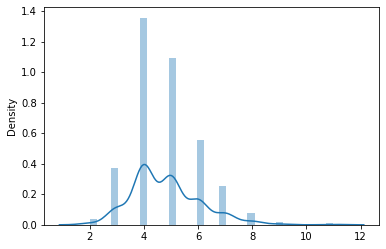

In [38]:
Bucket_Test_Results=Any_Tries_Test(words_historicals,BucketSolver)

Avg Tries: 4.122065727699531


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


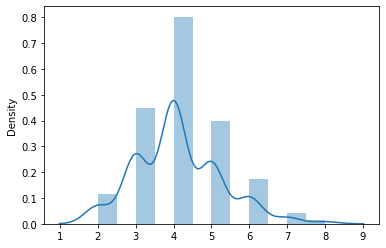

In [43]:
Frequency_Test_Results=Any_Tries_Test(words_historicals,FreqSolver)

# 6 Tries Test Results Below

Data: Historicals

In [46]:
Bucket_6_Tries=Six_Tries_Test(words_historicals,BucketSolver)

Number of Successes: 385
Length of Corpus: 426
Success %: 90.3755868544601


In [47]:
Freq_6_Tries=Six_Tries_Test(words_historicals,FreqSolver)

Number of Successes: 414
Length of Corpus: 426
Success %: 97.1830985915493


# Words Not Guessed  

Data: Historicals

In [49]:
print('Words missed in Bucket')
print(Bucket_Test_Results[1])

Words missed in Bucket
['BOOZY', 'BUGGY', 'COMMA', 'CORNY', 'CRAMP', 'CRASS', 'CRAZE', 'CRAZY', 'FAVOR', 'FINER', 'FIXER', 'FLOSS', 'FOYER', 'GLASS', 'GRIPE', 'HAIRY', 'HATCH', 'HINGE', 'HOMER', 'JAUNT', 'LIVER', 'LUSTY', 'NATAL', 'PITHY', 'POWER', 'PROVE', 'REPAY', 'SLUMP', 'STORE', 'STOVE', 'TEASE', 'TRITE', 'TROVE', 'UNFED', 'VOUCH', 'WACKY', 'WATCH', 'WEDGE', 'WROTE', 'YIELD', 'ZESTY']


In [51]:
print('Words missed in Freq')
print(Frequency_Test_Results[1])

Words missed in Freq
['CRAZE', 'CREAK', 'FOYER', 'GAWKY', 'HATCH', 'HERON', 'SOWER', 'STOMP', 'STOVE', 'SWILL', 'TANGY', 'VOUCH']
